In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(popular, n=5):
    items = np.array(popular['item_id'])
    probability = np.array(popular['probability'])
    
    recs = np.random.choice(items, size=n, replace=False, p=probability)
    
    return recs.tolist()

In [5]:
%%time
popular = data_train.groupby('item_id')['sales_value'].sum().reset_index()

#как правило эта проблема решается через log(1 + x), в Numpy для этого есть специальная функция np.log1p()
#это также поможет обойти ситуацию с нулевыми продажами

popular['log'] = np.log1p(popular['sales_value'])
sum_ = popular.log.sum()
print(sum_)

#probability -- это условная вероятность сэмплирования товара
popular['probability'] = popular['log']/sum_.sum()

#сумма по всем товарам д.б. равна единице, проверим
popular.probability.sum()

popular

241205.8574273651
CPU times: total: 234 ms
Wall time: 229 ms


,item_id,sales_value,log,probability
0,25671,20.94,3.088311,0.000013
1,26081,0.99,0.688135,0.000003
2,26093,1.59,0.951658,0.000004
3,26190,1.54,0.932164,0.000004
4,26355,1.98,1.091923,0.000005
...,...,...,...,...
86860,17381856,0.00,0.000000,0.000000
86861,17382205,7.99,2.196113,0.000009
86862,17383227,4.49,1.702928,0.000007
86863,17827644,2.50,1.252763,0.000005


In [6]:
weighted_random_recommendation(popular,5)

[849457, 6533756, 999858, 6423772, 837760]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [7]:
result = pd.read_csv('./predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [8]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 2042 non-null   int64 
 1   actual                  2042 non-null   object
 2   random_recommendation   2042 non-null   object
 3   popular_recommendation  2042 non-null   object
 4   itemitem                2042 non-null   object
 5   cosine                  2042 non-null   object
 6   tfidf                   2042 non-null   object
 7   own_purchases           2042 non-null   object
dtypes: int64(1), object(7)
memory usage: 127.8+ KB


In [9]:
result['actual'] = ''.join(' '.join(l) for l in result['actual'].str.lstrip().str.split())
res = []
for i in range(len(result['actual'])):
    res.append(list(map(int, result['actual'][i].split(']')[0].split('[')[1].split(' ')[1:])))
result['actual'] =  pd.DataFrame({'actual':res})

res = []
for i in range(len(result['random_recommendation'])):
    res.append(list(map(int, result['random_recommendation'][i].split(']')[0].split('[')[1].split(',')[1:])))
result['random_recommendation'] =  pd.DataFrame({'random_recommendation':res})

res = []
for i in range(len(result['popular_recommendation'])):
    res.append(list(map(int, result['popular_recommendation'][i].split(']')[0].split('[')[1].split(',')[1:])))
result['popular_recommendation'] =  pd.DataFrame({'popular_recommendation':res})

res = []
for i in range(len(result['itemitem'])):
    res.append(list(map(int, result['itemitem'][i].split(']')[0].split('[')[1].split(',')[1:])))
result['itemitem'] =  pd.DataFrame({'itemitem':res})

res = []
for i in range(len(result['cosine'])):
    res.append(list(map(int, result['cosine'][i].split(']')[0].split('[')[1].split(',')[1:])))
result['cosine'] =  pd.DataFrame({'cosine':res})

res = []
for i in range(len(result['tfidf'])):
    res.append(list(map(int, result['tfidf'][i].split(']')[0].split('[')[1].split(',')[1:])))
result['tfidf'] =  pd.DataFrame({'tfidf':res})
    
res = []
for i in range(len(result['own_purchases'])):
    res.append(list(map(int, result['own_purchases'][i].split(']')[0].split('[')[1].split(',')[1:])))
result['own_purchases'] =  pd.DataFrame({'own_purchases':res})
                          
# for name in result.columns:
#     if  name != ('user_id' and 'actual'):
#         res = []
#         for i in range(len(result[name])):
#             res.append(list(map(int, result[name][i].split(']')[0].split('[')[1].split(',')[1:])))
#         result[name] =  pd.DataFrame({name:res})

In [10]:
def precision_at_k(recommended_list, bought_list, k):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
   
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision


def recall_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    recall = flags.sum() / len(bought_list)
    
    return recall

In [11]:
precision_at_5 = {}
precision_at_3 = {}
recall_at_5 = {}

In [12]:
precision_at_5['random_recommendation'] = result.apply(lambda row: precision_at_k(row['random_recommendation'], 
                                                                                  row['actual'], 5), axis=1).mean()
precision_at_5['popular_recommendation'] = result.apply(lambda row: precision_at_k(row['popular_recommendation'], 
                                                                                   row['actual'], 5), axis=1).mean()
precision_at_5['itemitem'] = result.apply(lambda row: precision_at_k(row['itemitem'], 
                                                                     row['actual'], 5), axis=1).mean()
precision_at_5['cosine'] = result.apply(lambda row: precision_at_k(row['cosine'], 
                                                                   row['actual'], 5), axis=1).mean()
precision_at_5['tfidf'] = result.apply(lambda row: precision_at_k(row['tfidf'], 
                                                                  row['actual'], 5), axis=1).mean()
precision_at_5['own_purchases'] = result.apply(lambda row: precision_at_k(row['own_purchases'], 
                                                                          row['actual'], 5), axis=1).mean()
max(precision_at_5, key=precision_at_5.get)

'own_purchases'

In [13]:
precision_at_3['random_recommendation'] = result.apply(lambda row: precision_at_k(row['random_recommendation'], 
                                                                                  row['actual'], 3), axis=1).mean()
precision_at_3['popular_recommendation'] = result.apply(lambda row: precision_at_k(row['popular_recommendation'], 
                                                                                   row['actual'], 3), axis=1).mean()
precision_at_3['itemitem'] = result.apply(lambda row: precision_at_k(row['itemitem'], 
                                                                     row['actual'], 3), axis=1).mean()
precision_at_3['cosine'] = result.apply(lambda row: precision_at_k(row['cosine'], 
                                                                   row['actual'], 3), axis=1).mean()
precision_at_3['tfidf'] = result.apply(lambda row: precision_at_k(row['tfidf'], 
                                                                  row['actual'], 3), axis=1).mean()
precision_at_3['own_purchases'] = result.apply(lambda row: precision_at_k(row['own_purchases'], 
                                                                          row['actual'], 5), axis=1).mean()
max(precision_at_3, key=precision_at_3.get)

'own_purchases'

In [14]:
recall_at_5['random_recommendation'] = result.apply(lambda row: recall_at_k(row['random_recommendation'], 
                                                                                  row['actual'], 5), axis=1).mean()
recall_at_5['popular_recommendation'] = result.apply(lambda row: recall_at_k(row['popular_recommendation'], 
                                                                                   row['actual'], 5), axis=1).mean()
recall_at_5['itemitem'] = result.apply(lambda row: recall_at_k(row['itemitem'], 
                                                                     row['actual'], 5), axis=1).mean()
recall_at_5['cosine'] = result.apply(lambda row: recall_at_k(row['cosine'], 
                                                                   row['actual'], 5), axis=1).mean()
recall_at_5['tfidf'] = result.apply(lambda row: recall_at_k(row['tfidf'], 
                                                                  row['actual'], 5), axis=1).mean()
recall_at_5['own_purchases'] = result.apply(lambda row: recall_at_k(row['own_purchases'], 
                                                                          row['actual'], 5), axis=1).mean()
max(recall_at_5, key=recall_at_5.get)

'popular_recommendation'

In [15]:
precision_at_5, precision_at_3, recall_at_5 

({'random_recommendation': 0.0006121449559255632,
  'popular_recommendation': 0.25,
  'itemitem': 0.15291380999020568,
  'cosine': 0.1928256611165524,
  'tfidf': 0.20004897159647406,
  'own_purchases': 0.2503687315634218},
 {'random_recommendation': 0.0004897159647404506,
  'popular_recommendation': 0.0,
  'itemitem': 0.1638916095331367,
  'cosine': 0.19637610186091894,
  'tfidf': 0.20323212536728538,
  'own_purchases': 0.2503687315634218},
 {'random_recommendation': 3.400805310697574e-05,
  'popular_recommendation': 0.013888888888889221,
  'itemitem': 0.0084952116661227,
  'cosine': 0.010712536728697562,
  'tfidf': 0.011113831755359885,
  'own_purchases': 0.01385488083578223})

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [16]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [17]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [18]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id']

6           1043142
8           1102651
9           6423775
10          9487839
12           897044
             ...   
2282311    13877226
2282314     1057256
2282315    12487271
2282316      836262
2282321      993339
Name: item_id, Length: 829774, dtype: int64

In [19]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
user_item_matrix.shape

(2499, 5001)

In [21]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [22]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [23]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K1'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.84 s
Wall time: 811 ms


In [24]:
%%time

model = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K2'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.67 s
Wall time: 806 ms


In [25]:
%%time

model = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K3'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 3 s
Wall time: 829 ms


In [26]:
%%time

model = ItemItemRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K4'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.89 s
Wall time: 804 ms


In [27]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K5'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 3 s
Wall time: 831 ms


In [28]:
%%time

model = ItemItemRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K6'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.95 s
Wall time: 849 ms


In [29]:
%%time

model = ItemItemRecommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K7'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.86 s
Wall time: 818 ms


In [30]:
precision_at_5_item = {}

In [31]:
precision_at_5_item['K1'] = result.apply(lambda row: precision_at_k(row['K1'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item['K2'] = result.apply(lambda row: precision_at_k(row['K2'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item['K3'] = result.apply(lambda row: precision_at_k(row['K3'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item['K4'] = result.apply(lambda row: precision_at_k(row['K4'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item['K5'] = result.apply(lambda row: precision_at_k(row['K5'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item['K6'] = result.apply(lambda row: precision_at_k(row['K6'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item['K7'] = result.apply(lambda row: precision_at_k(row['K7'], 
                                                               row['actual'], 5), axis=1).mean()
max(precision_at_5_item, key=precision_at_5_item.get), precision_at_5_item

('K1',
 {'K1': 0.2190662748938939,
  'K2': 0.16297747306561994,
  'K3': 0.19285014691478689,
  'K4': 0.15700293829578643,
  'K5': 0.14573947110675645,
  'K6': 0.15700293829578643,
  'K7': 0.15700293829578643})

In [32]:
%%time

model = CosineRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K1_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.94 s
Wall time: 883 ms


In [33]:
%%time

model = CosineRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K2_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 3.08 s
Wall time: 871 ms


In [34]:
%%time

model = CosineRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K3_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.48 s
Wall time: 744 ms


In [35]:
%%time

model = CosineRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K4_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.34 s
Wall time: 680 ms


In [36]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K5_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.61 s
Wall time: 765 ms


In [37]:
%%time

model = CosineRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K6_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.84 s
Wall time: 883 ms


In [38]:
%%time

model = CosineRecommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K7_Cosine'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.88 s
Wall time: 832 ms


In [39]:
precision_at_5_cos = {}

In [40]:
precision_at_5_cos['K1'] = result.apply(lambda row: precision_at_k(row['K1_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_cos['K2'] = result.apply(lambda row: precision_at_k(row['K2_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_cos['K3'] = result.apply(lambda row: precision_at_k(row['K3_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_cos['K4'] = result.apply(lambda row: precision_at_k(row['K4_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_cos['K5'] = result.apply(lambda row: precision_at_k(row['K5_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_cos['K6'] = result.apply(lambda row: precision_at_k(row['K6_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_cos['K7'] = result.apply(lambda row: precision_at_k(row['K7_Cosine'], 
                                                               row['actual'], 5), axis=1).mean()
max(precision_at_5_cos, key=precision_at_5_cos.get), precision_at_5_cos

('K3',
 {'K1': 0.10401567091087077,
  'K2': 0.1152791380999011,
  'K3': 0.13545543584720715,
  'K4': 0.13545543584720715,
  'K5': 0.13545543584720715,
  'K6': 0.13545543584720715,
  'K7': 0.13545543584720715})

In [41]:
%%time

model = BM25Recommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K1_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.88 s
Wall time: 848 ms


In [42]:
%%time

model = BM25Recommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K2_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 3.06 s
Wall time: 865 ms


In [43]:
%%time

model = BM25Recommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K3_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 3.06 s
Wall time: 977 ms


In [44]:
%%time

model = BM25Recommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K4_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 3.06 s
Wall time: 882 ms


In [45]:
%%time

model = BM25Recommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K5_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.8 s
Wall time: 839 ms


In [46]:
%%time

model = BM25Recommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K6_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.56 s
Wall time: 796 ms


In [47]:
%%time

model = BM25Recommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K7_BM25'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 2.75 s
Wall time: 810 ms


In [48]:
precision_at_5_bm25 = {}

In [49]:
precision_at_5_bm25['K1'] = result.apply(lambda row: precision_at_k(row['K1_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_bm25['K2'] = result.apply(lambda row: precision_at_k(row['K2_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_bm25['K3'] = result.apply(lambda row: precision_at_k(row['K3_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_bm25['K4'] = result.apply(lambda row: precision_at_k(row['K4_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_bm25['K5'] = result.apply(lambda row: precision_at_k(row['K5_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_bm25['K6'] = result.apply(lambda row: precision_at_k(row['K6_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_bm25['K7'] = result.apply(lambda row: precision_at_k(row['K7_BM25'], 
                                                               row['actual'], 5), axis=1).mean()
max(precision_at_5_bm25, key=precision_at_5_bm25.get), precision_at_5_bm25

('K4',
 {'K1': 0.01047992164544562,
  'K2': 0.010088148873653262,
  'K3': 0.028207639569050036,
  'K4': 0.11674828599412249,
  'K5': 0.1059745347698329,
  'K6': 0.05484818805093082,
  'K7': 0.05484818805093082})

In [50]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(2500).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id']
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [51]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K1_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.61 s
Wall time: 484 ms


In [52]:
%%time

model = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K2_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.53 s
Wall time: 444 ms


In [53]:
%%time

model = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K3_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.44 s
Wall time: 439 ms


In [54]:
%%time

model = ItemItemRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K4_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.55 s
Wall time: 463 ms


In [55]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K5_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.3 s
Wall time: 402 ms


In [56]:
%%time

model = ItemItemRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K6_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.59 s
Wall time: 467 ms


In [57]:
%%time

model = ItemItemRecommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

result['K7_3000'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=3, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])
del model

  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: total: 1.36 s
Wall time: 383 ms


In [58]:
precision_at_5_item_3000 = {}

In [59]:
precision_at_5_item_3000['K1'] = result.apply(lambda row: precision_at_k(row['K1'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item_3000['K2'] = result.apply(lambda row: precision_at_k(row['K2'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item_3000['K3'] = result.apply(lambda row: precision_at_k(row['K3'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item_3000['K4'] = result.apply(lambda row: precision_at_k(row['K4'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item_3000['K5'] = result.apply(lambda row: precision_at_k(row['K5'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item_3000['K6'] = result.apply(lambda row: precision_at_k(row['K6'], 
                                                               row['actual'], 5), axis=1).mean()
precision_at_5_item_3000['K7'] = result.apply(lambda row: precision_at_k(row['K7'], 
                                                               row['actual'], 5), axis=1).mean()
max(precision_at_5_item_3000, key=precision_at_5_item_3000.get), precision_at_5_item_3000

('K1',
 {'K1': 0.2190662748938939,
  'K2': 0.16297747306561994,
  'K3': 0.19285014691478689,
  'K4': 0.15700293829578643,
  'K5': 0.14573947110675645,
  'K6': 0.15700293829578643,
  'K7': 0.15700293829578643})

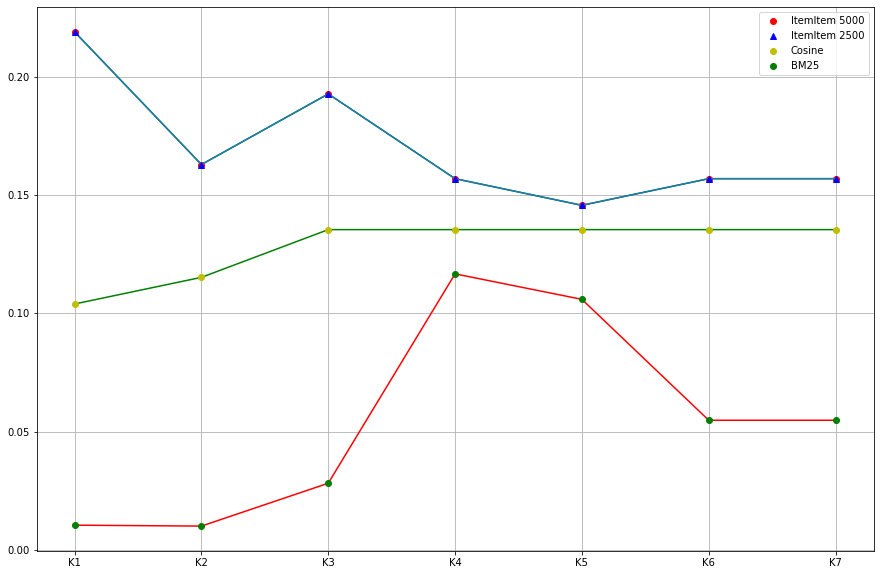

In [60]:
fig, ax = plt.subplots()

ax.plot(*zip(*precision_at_5_item.items()),'g')
ax.plot(*zip(*precision_at_5_item.items()),'ro', label='ItemItem 5000')
ax.plot(*zip(*precision_at_5_item_3000.items()))
ax.plot(*zip(*precision_at_5_item_3000.items()),'b^', label='ItemItem 2500')
ax.plot(*zip(*precision_at_5_cos.items()),'g')
ax.plot(*zip(*precision_at_5_cos.items()),'yo', label='Cosine')
ax.plot(*zip(*precision_at_5_bm25.items()),'r')
ax.plot(*zip(*precision_at_5_bm25.items()),'go', label='BM25')
ax.grid()
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(15)